In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import r2_score, confusion_matrix
import matplotlib.patches as mpatches
import time
import datetime
import scipy.fftpack

In [2]:
df = pd.read_csv('Amazon.csv')
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df.index = df['Date']

In [3]:
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1997-05-15,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


# Exploratory Data Analysis

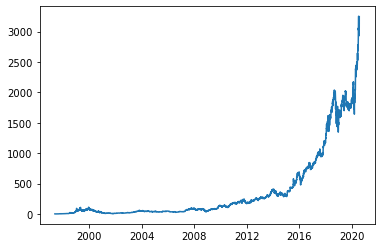

In [4]:
plt.plot(df['Date'], df['Open'])
plt.show()

# Creating time-lags

In [5]:
# These are the "time lags"
shifts = np.arange(1, 100).astype(int)
shifted_data = {"lag_{}_day".format(day_shift): df['Open'].shift(day_shift) for day_shift in shifts}
df_shifted = pd.DataFrame(shifted_data)
df_shifted.index = df.index
df_shifted.dropna(inplace=True)

In [6]:
df_shifted.head()

,lag_1_day,lag_2_day,lag_3_day,lag_4_day,lag_5_day,lag_6_day,lag_7_day,lag_8_day,lag_9_day,lag_10_day,...,lag_90_day,lag_91_day,lag_92_day,lag_93_day,lag_94_day,lag_95_day,lag_96_day,lag_97_day,lag_98_day,lag_99_day
Date,,,,,,,,,,,,,,,,,,,,,
1997-10-06,4.083333,4.041667,4.437500,4.000000,4.145833,4.072917,4.343750,4.645833,4.489583,4.000000,...,1.541667,1.625000,1.510417,1.406250,1.437500,1.635417,1.729167,1.760417,1.968750,2.437500
1997-10-07,4.000000,4.083333,4.041667,4.437500,4.000000,4.145833,4.072917,4.343750,4.645833,4.489583,...,1.500000,1.541667,1.625000,1.510417,1.406250,1.437500,1.635417,1.729167,1.760417,1.968750
1997-10-08,4.083333,4.000000,4.083333,4.041667,4.437500,4.000000,4.145833,4.072917,4.343750,4.645833,...,1.510417,1.500000,1.541667,1.625000,1.510417,1.406250,1.437500,1.635417,1.729167,1.760417
1997-10-09,4.145833,4.083333,4.000000,4.083333,4.041667,4.437500,4.000000,4.145833,4.072917,4.343750,...,1.531250,1.510417,1.500000,1.541667,1.625000,1.510417,1.406250,1.437500,1.635417,1.729167
1997-10-10,4.000000,4.145833,4.083333,4.000000,4.083333,4.041667,4.437500,4.000000,4.145833,4.072917,...,1.479167,1.531250,1.510417,1.500000,1.541667,1.625000,1.510417,1.406250,1.437500,1.635417


next we split the dataset into a train and test part. We choose to use the stock price between 2010 and 2019 as a training set and then test it on the 2019 data. The first model we try is the Ridge linear regression model

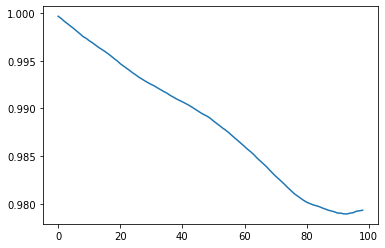

In [7]:
corrs = [ df['Open'].corr(df_shifted[col]) for col in df_shifted.columns]
plt.plot(np.array(range(99)), corrs)
plt.show()

In [8]:
data_range_train = [datetime.datetime(2010,1, 1), datetime.datetime(2019, 1, 1)]
data_range_test = [datetime.datetime(2019,1, 1), datetime.datetime(2020, 1, 1)]

X_train = df_shifted[data_range_train[0] : data_range_train[1]].values
y_train = df['Open'][data_range_train[0] : data_range_train[1]].values

X_test = df_shifted[data_range_test[0] : data_range_test[1]].values
y_test = df['Open'][data_range_test[0] : data_range_test[1]].values


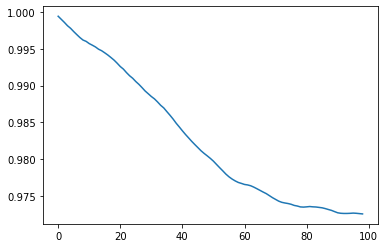

In [9]:
from scipy.stats import pearsonr

size = X_train.shape[1]
corrs = [ pearsonr(y_train,  X_train[:,i])[0] for i in range(size)]
plt.plot(range(size), corrs)
plt.show()

## Ridge Regression

In [10]:
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(X_train, y_train)
y_pred_ridge = model.predict(X_test)

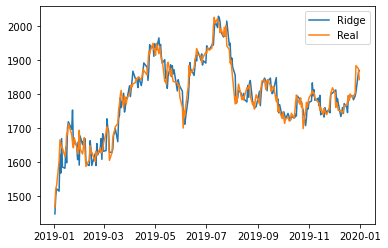

In [11]:
fig, ax = plt.subplots()
dates = df['Date'][data_range_test[0] : data_range_test[1]]
ax.plot(dates, y_pred_ridge, label = "Ridge")
ax.plot(dates, y_test, label = "Real")
ax.legend()
plt.show()

let's see how often the model was correctly predicting an increase in price. We can use the `numpy.diff` function to calculate the difference between sequential dates. By mapping this to positive/negative values, we can then use the `sklearn.metrics.confusion_matrix` function to compute the confusion matrix.

In [132]:
y_pred_diff = np.diff(y_pred) > 0
y_test_diff = np.diff(y_test) > 0
c_mat = confusion_matrix(y_pred_diff, y_test_diff)/len(y_pred_diff)
print(c_mat)
print(c_mat[0,0]+c_mat[1,1])
print(c_mat[0,1]+c_mat[1,0])

[[0.2310757  0.24302789]
 [0.23904382 0.28685259]]
0.5179282868525896
0.4820717131474104


In [12]:
# Create KFold cross-validation object
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=False)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X_train, y_train):
    # Fit the model on training data
    model.fit(X_train[tr], y_train[tr])
    
    # Generate predictions on the test data and collect
    prediction = model.predict(X_train[tt])
    results.append((prediction, tt))
    
# Custom function to quickly visualize predictions
# print(results)

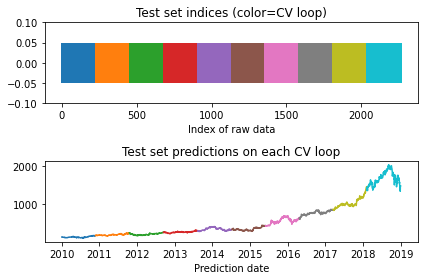

In [13]:
fig, axs = plt.subplots(2, 1)

for pred, tt in results:
    dates_viz = df['Date'][data_range_train[0] : data_range_train[1]][tt]
# Plot the indices chosen for validation on each loop
    axs[0].scatter(tt, [0] * len(tt), marker='_', s=2, lw=40)
    axs[0].set(ylim=[-.1, .1], title='Test set indices (color=CV loop)',
    xlabel='Index of raw data')
    # Plot the model predictions on each iteration
    axs[1].plot(dates_viz, pred)
    axs[1].set(title='Test set predictions on each CV loop',
    xlabel='Prediction date')
# axs[2].plot(df['Date'][data_range_train[0] : data_range_train[1]], y_train)
plt.tight_layout()

In [14]:
from sklearn.model_selection import cross_val_score

def display_scores(score):
    print("scores: ", score)
    print("mean: ",score.mean())
    print("standard deviation: ", score.std())
score = cross_val_score(model, X_train, y_train, cv=10, scoring = 'r2')
display_scores(score)

scores:  [0.95641654 0.9410019  0.93227399 0.93832224 0.96373099 0.96107262
 0.95504701 0.94837124 0.98167833 0.93968541]
mean:  0.9517600266217471
standard deviation:  0.014109989726373255


## Robert Regression

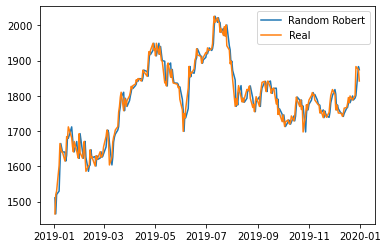

0.9399437334114354

In [27]:
y_test
y_pred = np.insert(y_test, 0, y_train[-1])
y_pred = np.delete(y_pred, -1)


fig, ax = plt.subplots()
dates = df['Date'][data_range_test[0] : data_range_test[1]]
ax.plot(dates, y_pred, label = "Random Robert")
# ax.plot(dates, y_pred_ridge, label = "Ridge")
ax.plot(dates, y_test, label = "Real")
ax.legend()
plt.show()

r2_score(y_pred, y_test)

## Random Forest Regression

In [24]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)
y_pred_rf = forest_reg.predict(X_test)

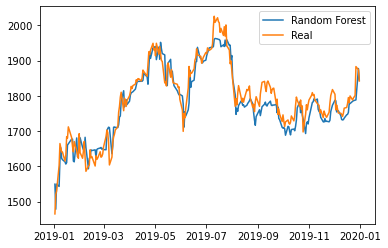

In [25]:
fig, ax = plt.subplots()
dates = df['Date'][data_range_test[0] : data_range_test[1]]
ax.plot(dates, y_pred_rf, label = "Random Forest")
# ax.plot(dates, y_pred_ridge, label = "Ridge")
ax.plot(dates, y_test, label = "Real")
ax.legend()
plt.show()

In [26]:
score = cross_val_score(forest_reg, X_train, y_train, cv=10, scoring = "r2")
display_scores(score)

scores:  [-3.74934198  0.86999352  0.77501203  0.62488837  0.15711415  0.93698256
 -0.16994324 -0.47671879  0.06195078 -2.34763136]
mean:  -0.3317693957561727
standard deviation:  1.4621507249292989


In [82]:
def display_scores(score_rf):
    print("scores", score_rf)
    print("mean",score_rf.mean())
    print("standard deviation", score_rf.std())
score = cross_val_score(model, X_train, y_train, cv=10)
display_scores(score)

In [159]:
display_scores(score_rf)

scores:  [-3.72390165  0.87441433  0.7789398   0.591712    0.11265822  0.9443959
 -0.04518916 -0.37943322  0.14597318 -2.38136815]
mean:  -0.3081798757987681
standard deviation:  1.4622576869326036


## Support Vector Regression

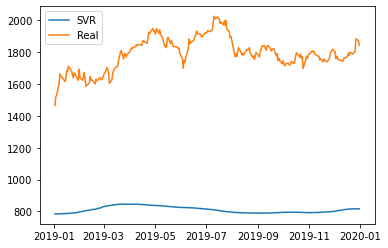

scores:  [-42.89194653  -4.90169601  -2.19220281   0.51424595  -0.22040389
   0.32812022   0.10534445   0.53527554  -4.28246555 -42.6017469 ]
mean:  -9.560747553169936
standard deviation:  16.69862022055976


In [31]:
from sklearn.svm import SVR
model = SVR()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

fig, ax = plt.subplots()
dates = df['Date'][data_range_test[0] : data_range_test[1]]
ax.plot(dates, y_pred, label = "SVR")
# ax.plot(dates, y_pred_ridge, label = "Ridge")
ax.plot(dates, y_test, label = "Real")
ax.legend()
plt.show()

score = cross_val_score(model, X_train, y_train, cv=10, scoring = "r2")
display_scores(score)

## Gaussian Process Regression

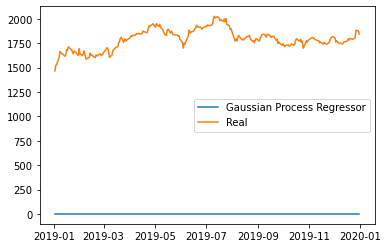

scores:  [ -67.54844302 -103.27021398  -87.37617359 -202.89151303  -91.06892418
  -71.91830437  -57.37685369 -214.04798783  -61.17835346  -93.13927549]
mean:  -104.98160426312225
standard deviation:  53.67296352910578


In [33]:
from sklearn.gaussian_process import GaussianProcessRegressor
model = GaussianProcessRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

fig, ax = plt.subplots()
dates = df['Date'][data_range_test[0] : data_range_test[1]]
ax.plot(dates, y_pred, label = "Gaussian Process Regressor")
# ax.plot(dates, y_pred_ridge, label = "Ridge")
ax.plot(dates, y_test, label = "Real")
ax.legend()
plt.show()

score = cross_val_score(model, X_train, y_train, cv=10, scoring = "r2")
display_scores(score)

In [34]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

# fourier transform

In [156]:
df_interpolate = df.set_index('Date').resample('1D').mean().interpolate('linear')


No handles with labels found to put in legend.


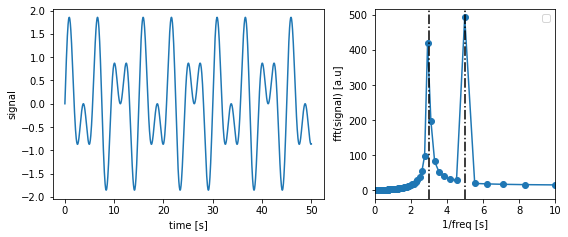

In [157]:
np.seterr(divide='ignore')

fig, axs = plt.subplots(1,2, gridspec_kw={'width_ratios': [1.5, 1]}, figsize = (8,2*1.7))

N = 1000
dt = 50/N

x = np.linspace(0,N*dt,N)
y = np.sin(2*np.pi*x/3) + 1*np.sin(2*np.pi*x/5)

axs[0].plot(x, y, label = "$\sin2\pi t/3+\sin2\pi t/5$")

axs[0].set_xlabel("time [s]")
axs[0].set_ylabel("signal")

yf = scipy.fftpack.fft(y)[:int(N/2)]
xf = np.linspace(0.0, 1/(2.0*dt), int(N/2))
axs[1].plot(1/xf, np.abs(yf))
axs[1].scatter(1/xf, np.abs(yf))

axs[1].set_xlim(0,10)
axs[1].set_xlabel("1/freq [s]")
axs[1].set_ylabel(" fft(signal) [a.u]")
axs[1].axvline(3, ls="-.", color="0")
axs[1].axvline(5, ls="-.", color="0")


plt.legend()

plt.tight_layout()
plt.show()

No handles with labels found to put in legend.


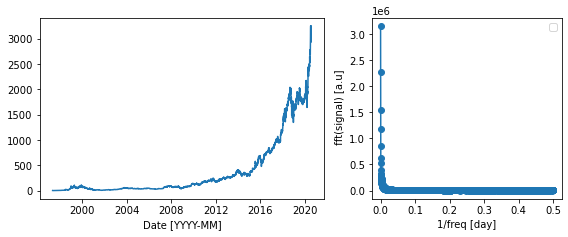

In [158]:
np.seterr(divide='ignore')

fig, axs = plt.subplots(1,2, gridspec_kw={'width_ratios': [1.5, 1]}, figsize = (8,2*1.7))

N = 1000
dt = 50/N

x = df_interpolate.index
y = df_interpolate['Open'].values

N = len(x)
dt = 1

axs[0].plot(x, y, label = "Amazon Stock Open")

axs[0].set_xlabel("Date [YYYY-MM]")

yf = scipy.fftpack.fft(y)[:int(N/2)]
xf = np.linspace(0.0, 1/(2.0*dt), int(N/2))
axs[1].plot(xf, np.abs(yf))
axs[1].scatter(xf, np.abs(yf))

# axs[1].set_xlim([0,50])
# axs[1].set_ylim([0,50000])
# axs[1].relim()
# axs[1].autoscale(axis='y')
axs[1].set_xlabel("1/freq [day]")
axs[1].set_ylabel(" fft(signal) [a.u]")
# axs[1].set_yscale('log')

plt.legend()

plt.tight_layout()
plt.show()